In [0]:
import torch
import torchvision
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import TensorDataset, DataLoader, random_split

In [0]:
batch_size=64
learning_rate=5e-7

DATASET_URL = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
DATA_FILENAME = "BostonHousing.csv"
TARGET_COLUMN = 'medv'
input_size=13
output_size=1

Dataset & Data loaders

In [3]:
download_url(DATASET_URL, '.')
data = pd.read_csv(DATA_FILENAME)
data.head()

Using downloaded and verified file: ./BostonHousing.csv


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
inputs = data.drop('medv', axis=1).values
targets = data[['medv']].values
inputs.shape, targets.shape

((506, 13), (506, 1))

In [0]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), 
                        torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [406, 100])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

Model

In [0]:
class HousingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch + 1}] -> val_loss: {result['val_loss']:.4f}")
    
model = HousingModel()

Training

In [0]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [8]:
result = evaluate(model, val_loader)
result

{'val_loss': 6192.29296875}

In [9]:
history = fit(100, learning_rate, model, train_loader, val_loader)

Epoch [1] -> val_loss: 1833.5920
Epoch [2] -> val_loss: 1342.7697
Epoch [3] -> val_loss: 1005.7144
Epoch [4] -> val_loss: 754.0838
Epoch [5] -> val_loss: 598.9290
Epoch [6] -> val_loss: 459.4538
Epoch [7] -> val_loss: 379.9926
Epoch [8] -> val_loss: 306.9252
Epoch [9] -> val_loss: 257.2711
Epoch [10] -> val_loss: 223.8154
Epoch [11] -> val_loss: 201.1247
Epoch [12] -> val_loss: 182.0794
Epoch [13] -> val_loss: 169.3010
Epoch [14] -> val_loss: 159.2343
Epoch [15] -> val_loss: 152.5123
Epoch [16] -> val_loss: 147.5727
Epoch [17] -> val_loss: 143.6984
Epoch [18] -> val_loss: 139.6168
Epoch [19] -> val_loss: 137.4597
Epoch [20] -> val_loss: 135.6438
Epoch [21] -> val_loss: 134.1633
Epoch [22] -> val_loss: 133.2424
Epoch [23] -> val_loss: 131.6424
Epoch [24] -> val_loss: 132.2301
Epoch [25] -> val_loss: 130.1481
Epoch [26] -> val_loss: 128.8749
Epoch [27] -> val_loss: 130.5497
Epoch [28] -> val_loss: 128.1843
Epoch [29] -> val_loss: 127.0099
Epoch [30] -> val_loss: 126.9768
Epoch [31] -> va

Text(0.5, 1.0, 'val_loss vs. epochs')

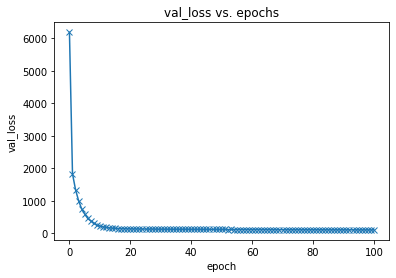

In [10]:
losses = [r['val_loss'] for r in [result] + history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs')

Prediction

In [0]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(xb).item()

In [12]:
x, target = val_ds[12]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([2.2438e-01, 0.0000e+00, 9.6900e+00, 0.0000e+00, 5.8500e-01, 6.0270e+00,
        7.9700e+01, 2.4982e+00, 6.0000e+00, 3.9100e+02, 1.9200e+01, 3.9690e+02,
        1.4330e+01])
Target:  16.799999237060547
Prediction: 19.04083251953125


Save Model

In [0]:
torch.save(model.state_dict(), 'housing-linear.pth')